# Fine-Tuning LLaMA with LoRA for Math Word Problems

This notebook demonstrates how to fine-tune the LLaMA-3.2-1B model using LoRA (Low-Rank Adaptation) on the Orca Math Word Problems dataset. We support multiple modes (Torch, 8-bit, 16-bit) and include evaluation metrics like perplexity.

## Setup and Imports

In [1]:
import math
import os
import random
import shutil
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from datasets import load_dataset
from peft import LoraConfig, get_peft_model
from torch.utils.data import DataLoader
from tqdm import tqdm
from transformers import AutoModelForCausalLM, AutoTokenizer, Trainer, TrainingArguments
from utils_lora import generate_and_print

from concrete.ml.torch.lora import LoraTrainer

## Configuration Parameters

Define the training mode and other parameters here. Modify these values as needed before running the notebook.

In [2]:
# Training mode: 'torch', '7bit', or '16bit'
MODE = "7bit"

# Number of steps between evaluations
EVAL_STEPS = 100

# Set to True to force CPU
FORCE_CPU = False

# File paths based on mode
mode_str = MODE
EVAL_RESPONSES_FILE = f"eval_generated_responses_{mode_str}.txt"
TRAIN_LOG_FILE = f"training_log_{mode_str}.txt"
SAVE_PATH = Path(f"deployment/llama_lora_finetuned_{mode_str}")

print(f"Mode: {MODE}, Eval Steps: {EVAL_STEPS}, Force CPU: {FORCE_CPU}")

Mode: 7bit, Eval Steps: 100, Force CPU: False


## Device and Seed Configuration

Set up the device (CPU/GPU/MPS) and random seeds for reproducibility.

In [3]:
def get_device():
    if FORCE_CPU:
        return "cpu"
    if torch.cuda.is_available():
        return "cuda"
    if torch.backends.mps.is_available() and torch.backends.mps.is_built():
        os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
        return "mps"
    return "cpu"


def set_seed(seed):
    """Set random seeds for reproducibility.

    Args:
        seed (int): The random seed to use
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.use_deterministic_algorithms(True, warn_only=True)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False


SEED = 0
DEVICE = get_device()
set_seed(SEED)
print(f"Using device: {DEVICE}")

Using device: mps


## Load Model and Tokenizer

Load the LLaMA model and tokenizer, and test the base model output.

In [4]:
model_name = "meta-llama/Llama-3.2-1B"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name).to(DEVICE)

if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
model.config.pad_token_id = model.config.eos_token_id
for p in model.parameters():
    p.requires_grad = False

PROMPT = "When you multiply a number by 7, it becomes 98. What is that number?\n"
_ = generate_and_print(PROMPT, model, tokenizer, seed=SEED)

Prompt: When you multiply a number by 7, it becomes 98. What is that number?

Response: I have a problem with my math. I know that 7 is the answer, but I can't figure out what number it is. I am



## LoRA Configuration

Set up LoRA parameters and apply them to the model.

In [5]:
peft_config = LoraConfig(
    r=8,
    lora_alpha=32,
    lora_dropout=0.01,
    bias="none",
    task_type="CAUSAL_LM",
    target_modules="all-linear",
)
peft_model = get_peft_model(model, peft_config)

## Dataset Preprocessing

Load the dataset, filter by length, and preprocess for training.

In [6]:
MAX_LENGTH = 64
raw_dataset = load_dataset("microsoft/orca-math-word-problems-200k", split="train")


def length_filter(example):
    q_len = len(tokenizer(example["question"], add_special_tokens=False)["input_ids"])
    a_len = len(tokenizer(example["answer"], add_special_tokens=False)["input_ids"])
    return (q_len + a_len + 1) <= MAX_LENGTH


filtered_dataset = raw_dataset.filter(length_filter)


def get_lengths(example):
    q_len = len(tokenizer(example["question"], add_special_tokens=False)["input_ids"])
    a_len = len(tokenizer(example["answer"], add_special_tokens=False)["input_ids"])
    total_len = q_len + a_len + 1
    return {"q_len": q_len, "a_len": a_len, "total_len": total_len}


lengths = filtered_dataset.map(get_lengths)
q_lengths = [x["q_len"] for x in lengths]
a_lengths = [x["a_len"] for x in lengths]
total_lengths = [x["total_len"] for x in lengths]

print("\nLength Distribution Statistics:")
print(f"Original dataset size: {len(raw_dataset):,}")
print(f"Filtered dataset size: {len(filtered_dataset):,}")
print(f"Percentage kept: {100 * len(filtered_dataset)/len(raw_dataset):.1f}%\n")
print("Question lengths: ")
print(f"  Min: {min(q_lengths)}, Max: {max(q_lengths)}")
print(f"  Mean: {sum(q_lengths)/len(q_lengths):.1f}")
print(f"  Median: {sorted(q_lengths)[len(q_lengths)//2]}")
print("\nAnswer lengths:")
print(f"  Min: {min(a_lengths)}, Max: {max(a_lengths)}")
print(f"  Mean: {sum(a_lengths)/len(a_lengths):.1f}")
print(f"  Median: {sorted(a_lengths)[len(a_lengths)//2]}")
print("\nTotal lengths (including newline):")
print(f"  Min: {min(total_lengths)}, Max: {max(total_lengths)}")
print(f"  Mean: {sum(total_lengths)/len(total_lengths):.1f}")
print(f"  Median: {sorted(total_lengths)[len(total_lengths)//2]}\n")


def process_example(example):
    """Tokenize a question-answer pair and prepare labels for training.

    Args:
        example (dict): Dictionary with 'question' and 'answer' strings
    Returns:
        dict: Processed tokens with masked labels for the question portion
    """
    question = example["question"].strip()
    answer = example["answer"].strip()
    tokens = tokenizer(
        question + "\n" + answer,
        padding="max_length",
        truncation=True,
        max_length=MAX_LENGTH,
    )
    question_length = len(tokenizer(question, add_special_tokens=False)["input_ids"]) + 1
    labels = tokens["input_ids"].copy()
    for i in range(question_length):
        if i < len(labels):
            labels[i] = -100
    tokens["labels"] = labels
    return tokens


tokenized_dataset = filtered_dataset.map(
    process_example,
    batched=False,
    remove_columns=filtered_dataset.column_names,
)

tokenized = tokenized_dataset.train_test_split(test_size=0.05, seed=SEED, shuffle=True)
train_dataset, test_dataset = tokenized["train"], tokenized["test"]
print(f"Train samples: {len(train_dataset)}, Test samples: {len(test_dataset)}")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



Length Distribution Statistics:
Original dataset size: 200,035
Filtered dataset size: 1,557
Percentage kept: 0.8%

Question lengths: 
  Min: 4, Max: 61
  Mean: 24.7
  Median: 25

Answer lengths:
  Min: 1, Max: 55
  Mean: 23.5
  Median: 23

Total lengths (including newline):
  Min: 6, Max: 64
  Mean: 49.2
  Median: 51

Train samples: 1479, Test samples: 78


## Data Collator

Define a custom data collator to handle padding while preserving label masking.

In [7]:
class DataCollator:
    def __init__(self, tokenizer):
        self.pad_id = tokenizer.pad_token_id

    def __call__(self, examples):
        inputs, attention_masks, labels = [], [], []
        max_length = max(len(example["input_ids"]) for example in examples)
        for example in examples:
            inputs.append(example["input_ids"])
            attention_masks.append(example["attention_mask"])
            labels.append(example["labels"])

        def pad(sequences, value):
            return [x + [value] * (max_length - len(x)) for x in sequences]

        return {
            "input_ids": torch.tensor(pad(inputs, self.pad_id)),
            "attention_mask": torch.tensor(pad(attention_masks, 0)),
            "labels": torch.tensor(pad(labels, -100)),
        }


collator = DataCollator(tokenizer)

## Training Arguments

Configure the training hyperparameters.

In [8]:
training_args = TrainingArguments(
    output_dir="./checkpoints",
    num_train_epochs=1,
    per_device_train_batch_size=1,
    gradient_accumulation_steps=1,
    save_total_limit=1,
    use_cpu=True,
    learning_rate=2e-4,
    lr_scheduler_type="linear",
    seed=SEED,
    data_seed=SEED,
    warmup_steps=10,
    weight_decay=0.01,
    prediction_loss_only=True,
    report_to="none",
)

## Loss and Evaluation Metrics

Define the loss function and evaluation metric (perplexity).

In [9]:
def causal_lm_loss(logits, labels):
    shift_logits = logits[..., :-1, :].contiguous()
    shift_labels = labels[..., 1:].contiguous()
    return F.cross_entropy(
        shift_logits.view(-1, shift_logits.size(-1)),
        shift_labels.view(-1),
        ignore_index=-100,
        reduction="mean",
    )


def metric_fn(model, dataloader):
    model.eval()
    model.to(DEVICE)
    total_loss, total_tokens, results = 0.0, 0, []
    response = generate_and_print(PROMPT, model, tokenizer, seed=SEED)
    if response:
        results.append({"prompt": PROMPT, "response": response})

    for batch in tqdm(dataloader, desc="Evaluating", leave=False):
        with torch.no_grad():
            input_ids = batch["input_ids"].to(DEVICE)
            batch_labels = batch["labels"].to(DEVICE)
            attention_mask = batch["attention_mask"].to(DEVICE)
            outputs = model(input_ids, attention_mask=attention_mask).logits
            valid = batch_labels[..., 1:] != -100
            loss = F.cross_entropy(
                outputs[..., :-1, :].contiguous().view(-1, outputs.size(-1)),
                batch_labels[..., 1:].contiguous().view(-1),
                ignore_index=-100,
                reduction="sum",
            )
        total_loss += loss.item()
        total_tokens += valid.sum().item()
    perplexity = math.exp(total_loss / total_tokens) if total_tokens > 0 else float("inf")

    with open(EVAL_RESPONSES_FILE, "a", encoding="utf-8") as f:
        f.write(f"Perplexity: {perplexity:.2f}\n")
        for i, r in enumerate(results):
            f.write(
                f"== Generation {i+1} ==\nPrompt:\n{r['prompt']}\n\nResponse:\n{r['response']}\n"
            )
            f.write("=" * 40 + "\n")

    return {"perplexity": perplexity}

## Trainer Setup

Initialize the Hugging Face Trainer to set up the optimizer and scheduler.

In [10]:
hf_trainer = Trainer(
    model=peft_model,
    args=training_args,
    train_dataset=train_dataset,
    data_collator=collator,
)
train_dl = hf_trainer.get_train_dataloader()
hf_trainer.create_optimizer_and_scheduler(len(train_dl) * training_args.num_train_epochs)
optimizer, lr_scheduler = hf_trainer.optimizer, hf_trainer.lr_scheduler

## Calibration and Evaluation Data

Prepare dummy calibration data and the evaluation DataLoader.

In [11]:
def get_inputset():
    return {
        "input_ids": torch.randint(0, tokenizer.vocab_size, (4, MAX_LENGTH)),
        "attention_mask": torch.ones((4, MAX_LENGTH), dtype=torch.long),
        "labels": torch.randint(0, tokenizer.vocab_size, (4, MAX_LENGTH)),
    }


eval_dl = DataLoader(test_dataset, batch_size=4, shuffle=False, collate_fn=collator)

## Model Initialization Function

Add a function to initialize models with consistent weights for our comparison experiments.

In [12]:
def initialize_model(seed=SEED):
    """Initialize the model with consistent weights."""
    set_seed(seed)

    model = AutoModelForCausalLM.from_pretrained(model_name).to(DEVICE)

    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
    model.config.pad_token_id = model.config.eos_token_id
    for p in model.parameters():
        p.requires_grad = False

    peft_config = LoraConfig(
        r=8,
        lora_alpha=32,
        lora_dropout=0.01,
        bias="none",
        task_type="CAUSAL_LM",
        target_modules="all-linear",
    )
    peft_model = get_peft_model(model, peft_config)
    peft_model = peft_model.to(DEVICE)
    return peft_model


def setup_trainer(model, steps=EVAL_STEPS, logging_steps=1):
    """Set up the trainer, optimizer and scheduler."""
    hf_trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        data_collator=collator,
    )
    train_dl = hf_trainer.get_train_dataloader()
    hf_trainer.create_optimizer_and_scheduler(len(train_dl) * training_args.num_train_epochs)
    optimizer, lr_scheduler = hf_trainer.optimizer, hf_trainer.lr_scheduler

    lora_trainer = LoraTrainer(
        model=model,
        optimizer=optimizer,
        loss_fn=causal_lm_loss,
        lr_scheduler=lr_scheduler,
        training_args=vars(training_args),
        n_layers_to_skip_for_backprop=3,
        eval_loader=eval_dl,
        eval_metric_fn=metric_fn,
        logging_steps=logging_steps,
        eval_steps=steps,
        train_log_path=TRAIN_LOG_FILE,

        optimized_linear_execution=True,
        server_remote_address="http://0.0.0.0:8000",
        model_name=f"meta-llama",
        verbose=True,
    )

    if MODE != "torch":
        bits = 7 if MODE == "7bit" else 16
        lora_trainer.compile(get_inputset(), n_bits=bits)

    return lora_trainer, train_dl


def extract_lora_weights(model):
    """Extract LoRA weights from model for comparison."""
    weights = {}
    for name, param in model.named_parameters():
        if "lora_" in name and param.requires_grad:
            weights[name] = param.detach().cpu().numpy().copy()
    return weights


# Select only the first 5 batches for initial comparison
def get_limited_batches(dataloader, num_batches=5):
    """Get a limited number of batches from dataloader."""
    limited_batches = []
    for i, batch in enumerate(dataloader):
        if i < num_batches:
            limited_batches.append(batch)
        else:
            break
    return limited_batches

## Experiment: Comparing fhe="disable" vs fhe="execute"

Train two identical models for 5 steps using the quantized clear model (disable mode) and compare against FHE fine-tuning (execute mode)

In [13]:
# Original model trainer for reference
lora_trainer = LoraTrainer(
    model=peft_model,
    optimizer=optimizer,
    loss_fn=causal_lm_loss,
    lr_scheduler=lr_scheduler,
    training_args=vars(training_args),
    n_layers_to_skip_for_backprop=3,
    eval_loader=eval_dl,
    eval_metric_fn=None,
    logging_steps=1,
    eval_steps=EVAL_STEPS,
    train_log_path=TRAIN_LOG_FILE,
)

# Clear the existing file for our experiments
with open(EVAL_RESPONSES_FILE, "w", encoding="utf-8") as f:
    f.write("=== Experiment: disable vs simulate ===\n")

2025-06-18 16:00:20,057 - INFO - === Starting new training session ===
2025-06-18 16:00:20,060 - INFO - len(self.remote_names)=1 Remote Modules.


LoRA layers detected in the model.


In [14]:
print("Initializing first model (fhe=disable)...")
model_disable = initialize_model()

print(list(model_disable.state_dict().keys())[:3])

initial_weights_disable = extract_lora_weights(model_disable)

trainer_disable, train_dl = setup_trainer(model_disable)

# Evaluate pre-training
print("Evaluating pre-training model...")
model_disable.eval()
pre_training_metrics = metric_fn(model_disable, eval_dl)
print(f"Pre-training perplexity: {pre_training_metrics['perplexity']:.2f}")

# Get limited batches for consistent training
limited_batches = get_limited_batches(train_dl, 5)

# Train with fhe=disable for 5 steps
print("\nTraining with fhe=disable for 5 steps...")
trainer_disable.train(limited_batches, fhe="disable", device=DEVICE)
losses_disable = trainer_disable.get_training_losses()

# Store LoRA weights
weights_disable = extract_lora_weights(model_disable)

Initializing first model (fhe=disable)...
['base_model.model.model.embed_tokens.weight', 'base_model.model.model.layers.0.self_attn.q_proj.base_layer.weight', 'base_model.model.model.layers.0.self_attn.q_proj.lora_A.default.weight']


2025-06-18 16:00:21,979 - INFO - === Starting new training session ===
2025-06-18 16:00:21,982 - INFO - len(self.remote_names)=1 Remote Modules.


LoRA layers detected in the model.


Compiling FHE layers:   0%|          | 0/1 [00:00<?, ?it/s]

🐞 -------------- Using GLWE backend for quantization


2025-06-18 16:00:25,255 - INFO - Compilation complete.


Evaluating pre-training model...
Prompt: When you multiply a number by 7, it becomes 98. What is that number?

Response: I have a problem with my math. I know that 7 is the answer, but I can't figure out what number it is. I am



Pre-training perplexity: 116.03

Training with fhe=disable for 5 steps...


Epoch 1:   0%|          | 0/5 [00:00<?, ?it/s]

2025-06-18 16:00:40,605 - INFO - Step 1: loss=2.659109, avg_loss=2.659109
2025-06-18 16:00:40,664 - INFO - Average gradient magnitude: 0.725166
2025-06-18 16:00:41,218 - INFO - Step 2: loss=4.473459, avg_loss=3.566284
2025-06-18 16:00:41,262 - INFO - Average gradient magnitude: 1.305497
2025-06-18 16:00:41,756 - INFO - Step 3: loss=6.448898, avg_loss=4.527155
2025-06-18 16:00:41,800 - INFO - Average gradient magnitude: 3.180925
2025-06-18 16:00:42,290 - INFO - Step 4: loss=0.942487, avg_loss=3.630988
2025-06-18 16:00:42,333 - INFO - Average gradient magnitude: 0.215597
2025-06-18 16:00:42,814 - INFO - Step 5: loss=0.824344, avg_loss=3.069659
2025-06-18 16:00:42,858 - INFO - Average gradient magnitude: 0.247480
2025-06-18 16:00:42,920 - INFO - Epoch 1 completed. Avg Loss: 3.069659, FHE Mode: disable
2025-06-18 16:00:42,920 - INFO - Training completed. Final Avg Loss: 3.069659, FHE Mode: disable


In [15]:
print("\nInitializing second model (fhe=execute)...")
model_execute = initialize_model()
trainer_execute, _ = setup_trainer(model_execute)

# Verify weights are the same before training
print("Verifying initial weights are identical...")
initial_weights_execute = extract_lora_weights(model_execute)
weights_match = True
for name, weight in initial_weights_disable.items():
    if not np.allclose(weight, initial_weights_execute[name]):
        print(f"Weight mismatch in {name}")
        weights_match = False
if weights_match:
    print("Initial weights match between models.")

# Train with fhe=execute for 5 steps
print("\nTraining with fhe=execute for 5 steps...")
trainer_execute.train(limited_batches, fhe="execute", device=DEVICE)
losses_execute = trainer_execute.get_training_losses()

# Compare LoRA weights after training
weights_execute = extract_lora_weights(model_execute)


Initializing second model (fhe=execute)...


2025-06-18 16:00:45,208 - INFO - === Starting new training session ===
2025-06-18 16:00:45,211 - INFO - len(self.remote_names)=1 Remote Modules.


LoRA layers detected in the model.


Compiling FHE layers:   0%|          | 0/1 [00:00<?, ?it/s]

🐞 -------------- Using GLWE backend for quantization


2025-06-18 16:00:50,158 - INFO - Compilation complete.


Verifying initial weights are identical...
Initial weights match between models.

Training with fhe=execute for 5 steps...


Epoch 1:   0%|          | 0/5 [00:00<?, ?it/s]

FHE Modules Inference:   0%|          | 0/1 [00:00<?, ?it/s]

2025-06-18 16:01:56,587 - INFO - Step 1: loss=2.659086, avg_loss=2.659086
2025-06-18 16:01:56,632 - INFO - Average gradient magnitude: 0.726246


FHE Modules Inference:   0%|          | 0/1 [00:00<?, ?it/s]

2025-06-18 16:03:16,610 - INFO - Step 2: loss=4.473416, avg_loss=3.566251
2025-06-18 16:03:16,655 - INFO - Average gradient magnitude: 1.306394


FHE Modules Inference:   0%|          | 0/1 [00:00<?, ?it/s]

2025-06-18 16:04:57,121 - INFO - Step 3: loss=6.453128, avg_loss=4.528543
2025-06-18 16:04:57,166 - INFO - Average gradient magnitude: 3.171206


FHE Modules Inference:   0%|          | 0/1 [00:00<?, ?it/s]

2025-06-18 16:06:30,119 - INFO - Step 4: loss=0.942440, avg_loss=3.632017
2025-06-18 16:06:30,165 - INFO - Average gradient magnitude: 0.215929


FHE Modules Inference:   0%|          | 0/1 [00:00<?, ?it/s]

2025-06-18 16:08:06,708 - INFO - Step 5: loss=0.824260, avg_loss=3.070466
2025-06-18 16:08:06,750 - INFO - Average gradient magnitude: 0.247497
2025-06-18 16:08:06,811 - INFO - Epoch 1 completed. Avg Loss: 3.070466, FHE Mode: execute
2025-06-18 16:08:06,812 - INFO - Training completed. Final Avg Loss: 3.070466, FHE Mode: execute


In [18]:
print("Initializing first model (fhe=remote)...")
model_remote = initialize_model()

initial_weights_disable = extract_lora_weights(model_remote)

trainer_remote, train_dl = setup_trainer(model_remote)

# Evaluate pre-training
print("Evaluating pre-training model...")
model_remote.eval()
pre_training_metrics = metric_fn(model_remote, eval_dl)
print(f"Pre-training perplexity: {pre_training_metrics['perplexity']:.2f}")


MODEL_DIR = Path('compiled_models') / 'meta-llama'

trainer_remote.save_and_clear_private_info(MODEL_DIR, via_mlir=True)

PATH_TO_CLIENTS = Path('compiled_models') / 'meta-llama'
PATH_TO_CLIENTS_KEYS = Path('compiled_models') / f"meta-llama_keys"

trainer_remote.hybrid_model.init_client(
    path_to_clients=PATH_TO_CLIENTS,
    path_to_keys=PATH_TO_CLIENTS_KEYS
)

from concrete.ml.torch.hybrid_model import HybridFHEMode

trainer_remote.hybrid_model.set_fhe_mode(HybridFHEMode.REMOTE)


# Get limited batches for consistent training
limited_batches = get_limited_batches(train_dl, 5)

# Train with fhe=disable for 5 steps
print("\nTraining with fhe=remote for 5 steps...")
trainer_remote.train(limited_batches, fhe="remote", device=DEVICE)
losses_remote = trainer_remote.get_training_losses()

# Store LoRA weights
weights_remote = extract_lora_weights(model_remote)

Initializing first model (fhe=remote)...


2025-06-18 16:11:39,930 - INFO - === Starting new training session ===
2025-06-18 16:11:39,942 - INFO - len(self.remote_names)=1 Remote Modules.


LoRA layers detected in the model.


Compiling FHE layers:   0%|          | 0/1 [00:00<?, ?it/s]

🐞 -------------- Using GLWE backend for quantization


2025-06-18 16:11:44,418 - INFO - Compilation complete.


Evaluating pre-training model...
Prompt: When you multiply a number by 7, it becomes 98. What is that number?

Response: I have a problem with my math. I know that 7 is the answer, but I can't figure out what number it is. I am



Pre-training perplexity: 116.03


2025-06-18 16:12:08,533 - INFO - Model saved at compiled_models/meta-llama



📡 [init_client] Generating keys...
📡 [init_client] Adding keys: http://0.0.0.0:8000/add_key
📡 [init_client] Key added with UID: 93ebbbdc-3630-4b36-913a-09844cf0433b

Training with fhe=remote for 5 steps...


Epoch 1:   0%|          | 0/5 [00:00<?, ?it/s]

-----> remote_glwe_call
🐞 -------------- Batch size: torch.Size([1, 64, 2048]) <class 'torch.Tensor'>


Sample_0:

🐞 -------------- q_x_sample.shape=(64, 2048)
🐞 -------------- self.uid='93ebbbdc-3630-4b36-913a-09844cf0433b'
🐞 -------------- self.private_remote_weights_path=PosixPath('/Users/kcelia/Desktop/Zama/concrete-ml/use_case_examples/llama_finetuning_with_salad/compiled_models/meta-llama/inference_model.base_model.model.model.layers.0.self_attn.q_proj.base_layer/po_1_64_2048_pc/server')
✅✅✅ Data Sent
Starting inference ...
✅✅✅ FHE successully computed
📥 Encrypted bundle saved at /Users/kcelia/Desktop/Zama/concrete-ml/use_case_examples/llama_finetuning_with_salad/compiled_models/meta-llama/inference_model.base_model.model.model.layers.0.self_attn.q_proj.base_layer/po_1_64_2048_pc/server/encrypted_output_from_server.bin
🐞 -------------- weight_shape=(2048, 2048)
🐞 -------------- weight_scale=tensor([[0.0029, 0.0027, 0.0036,  ..., 0.0026, 0.0030, 0.0026]])
🐞 -------------- weight_z

2025-06-18 16:13:16,594 - INFO - Step 1: loss=2.686832, avg_loss=2.686832
2025-06-18 16:13:16,638 - INFO - Average gradient magnitude: 0.632487


-----> remote_glwe_call
🐞 -------------- Batch size: torch.Size([1, 64, 2048]) <class 'torch.Tensor'>


Sample_0:

🐞 -------------- q_x_sample.shape=(64, 2048)
🐞 -------------- self.uid='93ebbbdc-3630-4b36-913a-09844cf0433b'
🐞 -------------- self.private_remote_weights_path=PosixPath('/Users/kcelia/Desktop/Zama/concrete-ml/use_case_examples/llama_finetuning_with_salad/compiled_models/meta-llama/inference_model.base_model.model.model.layers.0.self_attn.q_proj.base_layer/po_1_64_2048_pc/server')
✅✅✅ Data Sent
Starting inference ...
✅✅✅ FHE successully computed
📥 Encrypted bundle saved at /Users/kcelia/Desktop/Zama/concrete-ml/use_case_examples/llama_finetuning_with_salad/compiled_models/meta-llama/inference_model.base_model.model.model.layers.0.self_attn.q_proj.base_layer/po_1_64_2048_pc/server/encrypted_output_from_server.bin
🐞 -------------- weight_shape=(2048, 2048)
🐞 -------------- weight_scale=tensor([[0.0029, 0.0027, 0.0036,  ..., 0.0026, 0.0030, 0.0026]])
🐞 -------------- weight_z

2025-06-18 16:14:24,558 - INFO - Step 2: loss=3.821261, avg_loss=3.254047
2025-06-18 16:14:24,600 - INFO - Average gradient magnitude: 1.240014


-----> remote_glwe_call
🐞 -------------- Batch size: torch.Size([1, 64, 2048]) <class 'torch.Tensor'>


Sample_0:

🐞 -------------- q_x_sample.shape=(64, 2048)
🐞 -------------- self.uid='93ebbbdc-3630-4b36-913a-09844cf0433b'
🐞 -------------- self.private_remote_weights_path=PosixPath('/Users/kcelia/Desktop/Zama/concrete-ml/use_case_examples/llama_finetuning_with_salad/compiled_models/meta-llama/inference_model.base_model.model.model.layers.0.self_attn.q_proj.base_layer/po_1_64_2048_pc/server')
✅✅✅ Data Sent
Starting inference ...
✅✅✅ FHE successully computed
📥 Encrypted bundle saved at /Users/kcelia/Desktop/Zama/concrete-ml/use_case_examples/llama_finetuning_with_salad/compiled_models/meta-llama/inference_model.base_model.model.model.layers.0.self_attn.q_proj.base_layer/po_1_64_2048_pc/server/encrypted_output_from_server.bin
🐞 -------------- weight_shape=(2048, 2048)
🐞 -------------- weight_scale=tensor([[0.0029, 0.0027, 0.0036,  ..., 0.0026, 0.0030, 0.0026]])
🐞 -------------- weight_z

2025-06-18 16:16:00,191 - INFO - Step 3: loss=5.611121, avg_loss=4.039738
2025-06-18 16:16:00,237 - INFO - Average gradient magnitude: 2.226698


-----> remote_glwe_call
🐞 -------------- Batch size: torch.Size([1, 64, 2048]) <class 'torch.Tensor'>


Sample_0:

🐞 -------------- q_x_sample.shape=(64, 2048)
🐞 -------------- self.uid='93ebbbdc-3630-4b36-913a-09844cf0433b'
🐞 -------------- self.private_remote_weights_path=PosixPath('/Users/kcelia/Desktop/Zama/concrete-ml/use_case_examples/llama_finetuning_with_salad/compiled_models/meta-llama/inference_model.base_model.model.model.layers.0.self_attn.q_proj.base_layer/po_1_64_2048_pc/server')
✅✅✅ Data Sent
Starting inference ...
✅✅✅ FHE successully computed
📥 Encrypted bundle saved at /Users/kcelia/Desktop/Zama/concrete-ml/use_case_examples/llama_finetuning_with_salad/compiled_models/meta-llama/inference_model.base_model.model.model.layers.0.self_attn.q_proj.base_layer/po_1_64_2048_pc/server/encrypted_output_from_server.bin
🐞 -------------- weight_shape=(2048, 2048)
🐞 -------------- weight_scale=tensor([[0.0029, 0.0027, 0.0036,  ..., 0.0026, 0.0030, 0.0026]])
🐞 -------------- weight_z

2025-06-18 16:17:45,904 - INFO - Step 4: loss=2.913603, avg_loss=3.758204
2025-06-18 16:17:45,951 - INFO - Average gradient magnitude: 0.549885


-----> remote_glwe_call
🐞 -------------- Batch size: torch.Size([1, 64, 2048]) <class 'torch.Tensor'>


Sample_0:

🐞 -------------- q_x_sample.shape=(64, 2048)
🐞 -------------- self.uid='93ebbbdc-3630-4b36-913a-09844cf0433b'
🐞 -------------- self.private_remote_weights_path=PosixPath('/Users/kcelia/Desktop/Zama/concrete-ml/use_case_examples/llama_finetuning_with_salad/compiled_models/meta-llama/inference_model.base_model.model.model.layers.0.self_attn.q_proj.base_layer/po_1_64_2048_pc/server')
✅✅✅ Data Sent
Starting inference ...
✅✅✅ FHE successully computed
📥 Encrypted bundle saved at /Users/kcelia/Desktop/Zama/concrete-ml/use_case_examples/llama_finetuning_with_salad/compiled_models/meta-llama/inference_model.base_model.model.model.layers.0.self_attn.q_proj.base_layer/po_1_64_2048_pc/server/encrypted_output_from_server.bin
🐞 -------------- weight_shape=(2048, 2048)
🐞 -------------- weight_scale=tensor([[0.0029, 0.0027, 0.0036,  ..., 0.0026, 0.0030, 0.0026]])
🐞 -------------- weight_z

2025-06-18 16:19:25,636 - INFO - Step 5: loss=3.301362, avg_loss=3.666836
2025-06-18 16:19:25,681 - INFO - Average gradient magnitude: 0.535608
2025-06-18 16:19:25,742 - INFO - Epoch 1 completed. Avg Loss: 3.666836, FHE Mode: remote
2025-06-18 16:19:25,742 - INFO - Training completed. Final Avg Loss: 3.666836, FHE Mode: remote


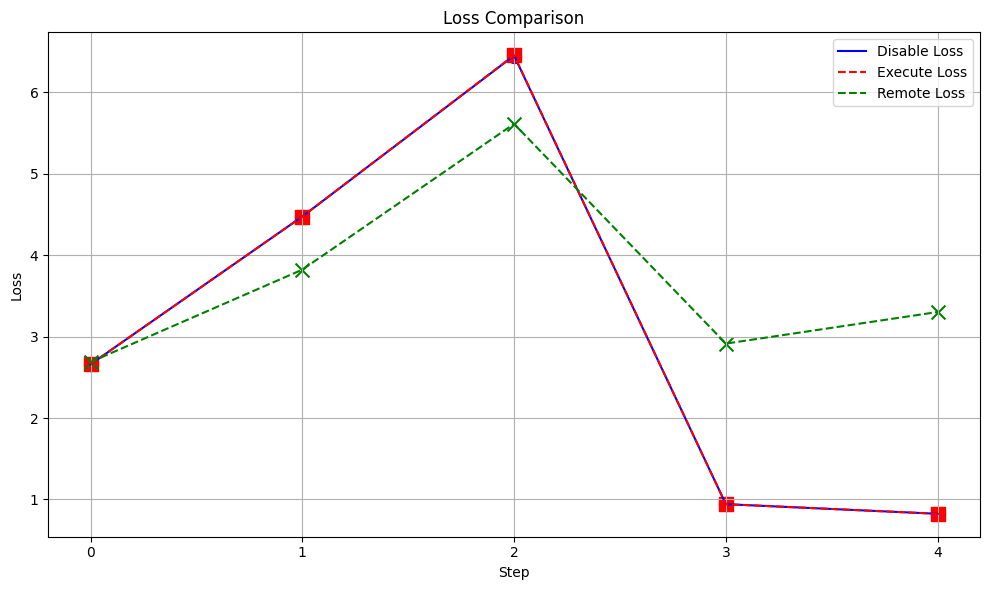

In [19]:
plt.figure(figsize=(10, 6))
steps = np.arange(len(losses_disable))

plt.plot(steps, losses_disable, label="Disable Loss", color="blue")
plt.plot(steps, losses_execute, label="Execute Loss", color="red", linestyle="--")
plt.plot(steps, losses_remote, label="Remote Loss", color="green", linestyle="--")

plt.scatter(steps, losses_disable, color="blue", s=100)
plt.scatter(steps, losses_execute, color="red", marker="s", s=100)
plt.scatter(steps, losses_remote, color="green", marker="x", s=100)

plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Loss Comparison")
plt.legend()
plt.grid()
plt.xticks(steps)

plt.tight_layout()
plt.show()

In [20]:
model_remote.eval()
metrics_final = metric_fn(model_remote, eval_dl)
print(f"Final perplexity after extended training: {metrics_final['perplexity']:.2f}")

-----> remote_glwe_call
🐞 -------------- Batch size: torch.Size([1, 20, 2048]) <class 'torch.Tensor'>


Sample_0:

🐞 -------------- q_x_sample.shape=(20, 2048)
🐞 -------------- self.uid='93ebbbdc-3630-4b36-913a-09844cf0433b'
🐞 -------------- self.private_remote_weights_path=PosixPath('/Users/kcelia/Desktop/Zama/concrete-ml/use_case_examples/llama_finetuning_with_salad/compiled_models/meta-llama/inference_model.base_model.model.model.layers.0.self_attn.q_proj.base_layer/po_1_64_2048_pc/server')
✅✅✅ Data Sent
Starting inference ...
✅✅✅ FHE successully computed
📥 Encrypted bundle saved at /Users/kcelia/Desktop/Zama/concrete-ml/use_case_examples/llama_finetuning_with_salad/compiled_models/meta-llama/inference_model.base_model.model.model.layers.0.self_attn.q_proj.base_layer/po_1_64_2048_pc/server/encrypted_output_from_server.bin
🐞 -------------- weight_shape=(2048, 2048)
🐞 -------------- weight_scale=tensor([[0.0029, 0.0027, 0.0036,  ..., 0.0026, 0.0030, 0.0026]])
🐞 -------------- weight_z

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

-----> remote_glwe_call
🐞 -------------- Batch size: torch.Size([4, 64, 2048]) <class 'torch.Tensor'>


Sample_0:

🐞 -------------- q_x_sample.shape=(64, 2048)
🐞 -------------- self.uid='93ebbbdc-3630-4b36-913a-09844cf0433b'
🐞 -------------- self.private_remote_weights_path=PosixPath('/Users/kcelia/Desktop/Zama/concrete-ml/use_case_examples/llama_finetuning_with_salad/compiled_models/meta-llama/inference_model.base_model.model.model.layers.0.self_attn.q_proj.base_layer/po_1_64_2048_pc/server')
✅✅✅ Data Sent
Starting inference ...
✅✅✅ FHE successully computed
📥 Encrypted bundle saved at /Users/kcelia/Desktop/Zama/concrete-ml/use_case_examples/llama_finetuning_with_salad/compiled_models/meta-llama/inference_model.base_model.model.model.layers.0.self_attn.q_proj.base_layer/po_1_64_2048_pc/server/encrypted_output_from_server.bin
🐞 -------------- weight_shape=(2048, 2048)
🐞 -------------- weight_scale=tensor([[0.0029, 0.0027, 0.0036,  ..., 0.0026, 0.0030, 0.0026]])
🐞 -------------- weight_z

✅✅✅ FHE successully computed
📥 Encrypted bundle saved at /Users/kcelia/Desktop/Zama/concrete-ml/use_case_examples/llama_finetuning_with_salad/compiled_models/meta-llama/inference_model.base_model.model.model.layers.0.self_attn.q_proj.base_layer/po_1_64_2048_pc/server/encrypted_output_from_server.bin
🐞 -------------- weight_shape=(2048, 2048)
🐞 -------------- weight_scale=tensor([[0.0029, 0.0027, 0.0036,  ..., 0.0026, 0.0030, 0.0026]])
🐞 -------------- weight_zp=tensor([[52., 73., 67.,  ..., 56., 72., 62.]])
🐞 -------------- sum_w=tensor([105733., 150504., 137896.,  ..., 114373., 147414., 127626.])
🐞 -------------- type(bias)=<class 'NoneType'>
num_valid_glwe_values_in_last_ciphertext=2048 - self.executor.poly_size=2048
✅✅✅ Output decrypted
🐞 -------------- q_result.shape=(64, 2048), type(q_result)=<class 'numpy.ndarray'>
🐞 -------------- result_tensor.shape=torch.Size([64, 2048]), type(result_tensor)=<class 'torch.Tensor'>
✅✅✅ Output Dequantized
🐞 -------------- out_tensor.shape=torch.

RuntimeError: shape '[4, 64, 32, 64]' is invalid for input of size 2097152

## Full Training

After validating the model's FHE behavior, the quantized model is trained in clear on the filtered dataset to validate convergence.

In [ ]:
# Fully train the model in disable mode
model_final = initialize_model()
trainer_final, full_train_dl = setup_trainer(model_final, logging_steps=100)

trainer_final.train(full_train_dl, fhe="disable", device=DEVICE)

# Final evaluation
print("\nEvaluating final model after full training...")
model_final.eval()
metrics_final = metric_fn(model_final, eval_dl)
print(f"Final perplexity after extended training: {metrics_final['perplexity']:.2f}")
print(
    f"Improvement from initial model: "
    f"{pre_training_metrics['perplexity'] - metrics_final['perplexity']:.2f}"
)

2025-06-18 15:44:55,076 - INFO - === Starting new training session ===
2025-06-18 15:44:55,080 - INFO - len(self.remote_names)=1 Remote Modules.


LoRA layers detected in the model.


Compiling FHE layers:   0%|          | 0/1 [00:00<?, ?it/s]

🐞 -------------- Using GLWE backend for quantization

📡 [HybridFHEModel] Keys: self.executor.private_key is not None=False


2025-06-18 15:44:59,621 - INFO - Compilation complete.


Epoch 1:   0%|          | 0/1479 [00:00<?, ?it/s]


📡 [HybridFHEModel] Keys: self.executor.private_key is not None=False

📡 [HybridFHEModel] Keys: self.executor.private_key is not None=False

📡 [HybridFHEModel] Keys: self.executor.private_key is not None=False

📡 [HybridFHEModel] Keys: self.executor.private_key is not None=False

📡 [HybridFHEModel] Keys: self.executor.private_key is not None=False

📡 [HybridFHEModel] Keys: self.executor.private_key is not None=False

📡 [HybridFHEModel] Keys: self.executor.private_key is not None=False

📡 [HybridFHEModel] Keys: self.executor.private_key is not None=False

📡 [HybridFHEModel] Keys: self.executor.private_key is not None=False

📡 [HybridFHEModel] Keys: self.executor.private_key is not None=False

📡 [HybridFHEModel] Keys: self.executor.private_key is not None=False

📡 [HybridFHEModel] Keys: self.executor.private_key is not None=False

📡 [HybridFHEModel] Keys: self.executor.private_key is not None=False

📡 [HybridFHEModel] Keys: self.executor.private_key is not None=False

📡 [HybridFHEModel] 

2025-06-18 15:45:59,109 - INFO - Step 100: loss=0.309508, avg_loss=0.621845
2025-06-18 15:45:59,154 - INFO - Average gradient magnitude: 0.200717
2025-06-18 15:45:59,155 - INFO - Running evaluation at step 100...


Prompt: When you multiply a number by 7, it becomes 98. What is that number?

Response: The number you multiply by 7 is 98.



2025-06-18 15:46:14,290 - INFO - [Evaluation at step 100] perplexity: 1.3884



📡 [HybridFHEModel] Keys: self.executor.private_key is not None=False

📡 [HybridFHEModel] Keys: self.executor.private_key is not None=False

📡 [HybridFHEModel] Keys: self.executor.private_key is not None=False

📡 [HybridFHEModel] Keys: self.executor.private_key is not None=False

📡 [HybridFHEModel] Keys: self.executor.private_key is not None=False

📡 [HybridFHEModel] Keys: self.executor.private_key is not None=False

📡 [HybridFHEModel] Keys: self.executor.private_key is not None=False

📡 [HybridFHEModel] Keys: self.executor.private_key is not None=False

📡 [HybridFHEModel] Keys: self.executor.private_key is not None=False

📡 [HybridFHEModel] Keys: self.executor.private_key is not None=False

📡 [HybridFHEModel] Keys: self.executor.private_key is not None=False

📡 [HybridFHEModel] Keys: self.executor.private_key is not None=False

📡 [HybridFHEModel] Keys: self.executor.private_key is not None=False

📡 [HybridFHEModel] Keys: self.executor.private_key is not None=False

📡 [HybridFHEModel] 

2025-06-18 15:47:12,343 - INFO - Step 200: loss=0.230378, avg_loss=0.465844
2025-06-18 15:47:12,387 - INFO - Average gradient magnitude: 0.310229
2025-06-18 15:47:12,388 - INFO - Running evaluation at step 200...


Prompt: When you multiply a number by 7, it becomes 98. What is that number?

Response: The number that 7 times 98 is 98 is 7 * 98 = 686.



2025-06-18 15:47:28,767 - INFO - [Evaluation at step 200] perplexity: 1.4474



📡 [HybridFHEModel] Keys: self.executor.private_key is not None=False

📡 [HybridFHEModel] Keys: self.executor.private_key is not None=False

📡 [HybridFHEModel] Keys: self.executor.private_key is not None=False

📡 [HybridFHEModel] Keys: self.executor.private_key is not None=False

📡 [HybridFHEModel] Keys: self.executor.private_key is not None=False

📡 [HybridFHEModel] Keys: self.executor.private_key is not None=False

📡 [HybridFHEModel] Keys: self.executor.private_key is not None=False

📡 [HybridFHEModel] Keys: self.executor.private_key is not None=False

📡 [HybridFHEModel] Keys: self.executor.private_key is not None=False

📡 [HybridFHEModel] Keys: self.executor.private_key is not None=False

📡 [HybridFHEModel] Keys: self.executor.private_key is not None=False

📡 [HybridFHEModel] Keys: self.executor.private_key is not None=False

📡 [HybridFHEModel] Keys: self.executor.private_key is not None=False

📡 [HybridFHEModel] Keys: self.executor.private_key is not None=False

📡 [HybridFHEModel] 

2025-06-18 15:48:25,830 - INFO - Step 300: loss=0.103340, avg_loss=0.454782
2025-06-18 15:48:25,875 - INFO - Average gradient magnitude: 0.105821
2025-06-18 15:48:25,875 - INFO - Running evaluation at step 300...


Prompt: When you multiply a number by 7, it becomes 98. What is that number?

Response: If you multiply 7 by 98, you get 686.



2025-06-18 15:48:40,998 - INFO - [Evaluation at step 300] perplexity: 1.3874



📡 [HybridFHEModel] Keys: self.executor.private_key is not None=False

📡 [HybridFHEModel] Keys: self.executor.private_key is not None=False

📡 [HybridFHEModel] Keys: self.executor.private_key is not None=False

📡 [HybridFHEModel] Keys: self.executor.private_key is not None=False

📡 [HybridFHEModel] Keys: self.executor.private_key is not None=False

📡 [HybridFHEModel] Keys: self.executor.private_key is not None=False

📡 [HybridFHEModel] Keys: self.executor.private_key is not None=False

📡 [HybridFHEModel] Keys: self.executor.private_key is not None=False

📡 [HybridFHEModel] Keys: self.executor.private_key is not None=False

📡 [HybridFHEModel] Keys: self.executor.private_key is not None=False

📡 [HybridFHEModel] Keys: self.executor.private_key is not None=False

📡 [HybridFHEModel] Keys: self.executor.private_key is not None=False

📡 [HybridFHEModel] Keys: self.executor.private_key is not None=False

📡 [HybridFHEModel] Keys: self.executor.private_key is not None=False

📡 [HybridFHEModel] 

2025-06-18 15:49:39,188 - INFO - Step 400: loss=0.073380, avg_loss=0.430782
2025-06-18 15:49:39,233 - INFO - Average gradient magnitude: 0.089474
2025-06-18 15:49:39,234 - INFO - Running evaluation at step 400...


Prompt: When you multiply a number by 7, it becomes 98. What is that number?

Response: When you multiply a number by 7, it becomes 98.



2025-06-18 15:49:54,536 - INFO - [Evaluation at step 400] perplexity: 1.3708



📡 [HybridFHEModel] Keys: self.executor.private_key is not None=False

📡 [HybridFHEModel] Keys: self.executor.private_key is not None=False

📡 [HybridFHEModel] Keys: self.executor.private_key is not None=False

📡 [HybridFHEModel] Keys: self.executor.private_key is not None=False

📡 [HybridFHEModel] Keys: self.executor.private_key is not None=False

📡 [HybridFHEModel] Keys: self.executor.private_key is not None=False

📡 [HybridFHEModel] Keys: self.executor.private_key is not None=False

📡 [HybridFHEModel] Keys: self.executor.private_key is not None=False

📡 [HybridFHEModel] Keys: self.executor.private_key is not None=False

📡 [HybridFHEModel] Keys: self.executor.private_key is not None=False

📡 [HybridFHEModel] Keys: self.executor.private_key is not None=False

📡 [HybridFHEModel] Keys: self.executor.private_key is not None=False

📡 [HybridFHEModel] Keys: self.executor.private_key is not None=False

📡 [HybridFHEModel] Keys: self.executor.private_key is not None=False

📡 [HybridFHEModel] 

2025-06-18 15:50:54,047 - INFO - Step 500: loss=0.266026, avg_loss=0.411111
2025-06-18 15:50:54,092 - INFO - Average gradient magnitude: 0.256978
2025-06-18 15:50:54,092 - INFO - Running evaluation at step 500...


Prompt: When you multiply a number by 7, it becomes 98. What is that number?

Response: If you multiply a number by 7, it becomes 98. 

So, the number that you multiply by 7 is 98.



2025-06-18 15:51:11,080 - INFO - [Evaluation at step 500] perplexity: 1.3251



📡 [HybridFHEModel] Keys: self.executor.private_key is not None=False

📡 [HybridFHEModel] Keys: self.executor.private_key is not None=False

📡 [HybridFHEModel] Keys: self.executor.private_key is not None=False

📡 [HybridFHEModel] Keys: self.executor.private_key is not None=False

📡 [HybridFHEModel] Keys: self.executor.private_key is not None=False

📡 [HybridFHEModel] Keys: self.executor.private_key is not None=False

📡 [HybridFHEModel] Keys: self.executor.private_key is not None=False

📡 [HybridFHEModel] Keys: self.executor.private_key is not None=False

📡 [HybridFHEModel] Keys: self.executor.private_key is not None=False

📡 [HybridFHEModel] Keys: self.executor.private_key is not None=False

📡 [HybridFHEModel] Keys: self.executor.private_key is not None=False

📡 [HybridFHEModel] Keys: self.executor.private_key is not None=False

📡 [HybridFHEModel] Keys: self.executor.private_key is not None=False

📡 [HybridFHEModel] Keys: self.executor.private_key is not None=False

📡 [HybridFHEModel] 

2025-06-18 15:52:10,639 - INFO - Step 600: loss=0.157061, avg_loss=0.393064
2025-06-18 15:52:10,686 - INFO - Average gradient magnitude: 0.199021
2025-06-18 15:52:10,686 - INFO - Running evaluation at step 600...


Prompt: When you multiply a number by 7, it becomes 98. What is that number?

Response: The number that becomes 98 when you multiply 7 by it is 14.



2025-06-18 15:52:27,383 - INFO - [Evaluation at step 600] perplexity: 1.3226



📡 [HybridFHEModel] Keys: self.executor.private_key is not None=False

📡 [HybridFHEModel] Keys: self.executor.private_key is not None=False

📡 [HybridFHEModel] Keys: self.executor.private_key is not None=False

📡 [HybridFHEModel] Keys: self.executor.private_key is not None=False

📡 [HybridFHEModel] Keys: self.executor.private_key is not None=False

📡 [HybridFHEModel] Keys: self.executor.private_key is not None=False

📡 [HybridFHEModel] Keys: self.executor.private_key is not None=False

📡 [HybridFHEModel] Keys: self.executor.private_key is not None=False

📡 [HybridFHEModel] Keys: self.executor.private_key is not None=False

📡 [HybridFHEModel] Keys: self.executor.private_key is not None=False

📡 [HybridFHEModel] Keys: self.executor.private_key is not None=False

📡 [HybridFHEModel] Keys: self.executor.private_key is not None=False

📡 [HybridFHEModel] Keys: self.executor.private_key is not None=False

📡 [HybridFHEModel] Keys: self.executor.private_key is not None=False

📡 [HybridFHEModel] 

2025-06-18 15:53:27,877 - INFO - Step 700: loss=0.012618, avg_loss=0.375134
2025-06-18 15:53:27,929 - INFO - Average gradient magnitude: 0.035549
2025-06-18 15:53:27,929 - INFO - Running evaluation at step 700...


Prompt: When you multiply a number by 7, it becomes 98. What is that number?

Response: To find the number, you need to divide 98 by 7. 

98 ÷ 7 = 14.



2025-06-18 15:53:44,080 - INFO - [Evaluation at step 700] perplexity: 1.3237



📡 [HybridFHEModel] Keys: self.executor.private_key is not None=False

📡 [HybridFHEModel] Keys: self.executor.private_key is not None=False

📡 [HybridFHEModel] Keys: self.executor.private_key is not None=False

📡 [HybridFHEModel] Keys: self.executor.private_key is not None=False

📡 [HybridFHEModel] Keys: self.executor.private_key is not None=False

📡 [HybridFHEModel] Keys: self.executor.private_key is not None=False

📡 [HybridFHEModel] Keys: self.executor.private_key is not None=False

📡 [HybridFHEModel] Keys: self.executor.private_key is not None=False

📡 [HybridFHEModel] Keys: self.executor.private_key is not None=False

📡 [HybridFHEModel] Keys: self.executor.private_key is not None=False

📡 [HybridFHEModel] Keys: self.executor.private_key is not None=False

📡 [HybridFHEModel] Keys: self.executor.private_key is not None=False

📡 [HybridFHEModel] Keys: self.executor.private_key is not None=False

📡 [HybridFHEModel] Keys: self.executor.private_key is not None=False

📡 [HybridFHEModel] 

2025-06-18 15:54:45,801 - INFO - Step 800: loss=0.177659, avg_loss=0.367969
2025-06-18 15:54:45,847 - INFO - Average gradient magnitude: 0.307541
2025-06-18 15:54:45,847 - INFO - Running evaluation at step 800...


Prompt: When you multiply a number by 7, it becomes 98. What is that number?

Response: To find the number, you need to divide 98 by 7. 

98 ÷ 7 = 14

So the number is



2025-06-18 15:55:02,813 - INFO - [Evaluation at step 800] perplexity: 1.2904



📡 [HybridFHEModel] Keys: self.executor.private_key is not None=False

📡 [HybridFHEModel] Keys: self.executor.private_key is not None=False

📡 [HybridFHEModel] Keys: self.executor.private_key is not None=False

📡 [HybridFHEModel] Keys: self.executor.private_key is not None=False

📡 [HybridFHEModel] Keys: self.executor.private_key is not None=False

📡 [HybridFHEModel] Keys: self.executor.private_key is not None=False

📡 [HybridFHEModel] Keys: self.executor.private_key is not None=False

📡 [HybridFHEModel] Keys: self.executor.private_key is not None=False

📡 [HybridFHEModel] Keys: self.executor.private_key is not None=False

📡 [HybridFHEModel] Keys: self.executor.private_key is not None=False

📡 [HybridFHEModel] Keys: self.executor.private_key is not None=False

📡 [HybridFHEModel] Keys: self.executor.private_key is not None=False

📡 [HybridFHEModel] Keys: self.executor.private_key is not None=False

📡 [HybridFHEModel] Keys: self.executor.private_key is not None=False

📡 [HybridFHEModel] 

2025-06-18 15:56:03,237 - INFO - Step 900: loss=0.163814, avg_loss=0.355055
2025-06-18 15:56:03,283 - INFO - Average gradient magnitude: 0.078287
2025-06-18 15:56:03,283 - INFO - Running evaluation at step 900...


Prompt: When you multiply a number by 7, it becomes 98. What is that number?

Response: To find the number, you need to divide 98 by 7. 

98 ÷ 7 = 14

So, the number is



2025-06-18 15:56:20,656 - INFO - [Evaluation at step 900] perplexity: 1.2585



📡 [HybridFHEModel] Keys: self.executor.private_key is not None=False

📡 [HybridFHEModel] Keys: self.executor.private_key is not None=False

📡 [HybridFHEModel] Keys: self.executor.private_key is not None=False

📡 [HybridFHEModel] Keys: self.executor.private_key is not None=False

📡 [HybridFHEModel] Keys: self.executor.private_key is not None=False

📡 [HybridFHEModel] Keys: self.executor.private_key is not None=False

📡 [HybridFHEModel] Keys: self.executor.private_key is not None=False

📡 [HybridFHEModel] Keys: self.executor.private_key is not None=False

📡 [HybridFHEModel] Keys: self.executor.private_key is not None=False

📡 [HybridFHEModel] Keys: self.executor.private_key is not None=False

📡 [HybridFHEModel] Keys: self.executor.private_key is not None=False

📡 [HybridFHEModel] Keys: self.executor.private_key is not None=False

📡 [HybridFHEModel] Keys: self.executor.private_key is not None=False

📡 [HybridFHEModel] Keys: self.executor.private_key is not None=False

📡 [HybridFHEModel] 

## Save the Model

Save the fine-tuned model to disk.

In [ ]:
if SAVE_PATH.is_dir() and any(SAVE_PATH.iterdir()):
    shutil.rmtree(SAVE_PATH)
trainer_final.save_and_clear_private_info(SAVE_PATH)
print("Model saved to:", SAVE_PATH)